In [ ]:
import logging as l
from pathlib import Path

import torch

from looped_experiments.all import *
from looped_experiments.eval import *
import looped_experiments.wandb_utils as wu

In [ ]:
eval_overrides = ["training.batch_size=256", "training.eval_steps=20", "task.n_points=60","model.n_loops=100"]
eval_overrides += ["model.n_loop_window=100"] # set loop window the same as n_loops to get predictions for all loops

In [ ]:
base = get_config()
# filter out runs that don't have token decrement
filters = [lambda r: 'token_dec' in r.config['model']]
runs = wu.get_runs(base.wandb.project, wu.default_filters+filters)

In [ ]:
runs1 = {}
runs1[r"$k=5, d=1$"]= runs.pop('loop_L1_b20_T5_k5_d1')
runs1[r"$k=5, d=1, norep$"]= runs.pop('loop_L1_b20_T5_k5_d1_norep')
runs1[r"$k=5, d=2, norep$"]= runs.pop('loop_L1_b20_T5_k5_d2_norep')
runs1[r"$k=3, d=1$"]= runs.pop('loop_L1_b20_T5_k3_d1')
runs1[r"$d=0$"]= runs.pop('loop_L1_b20_T5_linear')
runs1[r"$k=5, d=100$"]= runs.pop('loop_L1_b20_T5_k5_d100')
runs1[r"$L=2, k=5, d=1$"]= runs.pop('loop_L2_b20_T5_k5_d1')

# $T=5, b=20$

## In-context examples

In [ ]:
wu.refresh_models(runs1.values())

In [ ]:
errs = {}
for k, v in runs1.items():
    cfg = get_config(cfg_dict=v.config, overrides=eval_overrides)
    loc = Path("../"+v.config['out_dir'])
    loc = loc/'model_last.pt' if (loc/'model_last.pt').exists() else loc/'model_90000+train.pt'
    errs[k] = eval(cfg, loc) 
res = aggregate_metrics(errs, cfg.task.n_dims)

<matplotlib.legend.Legend>

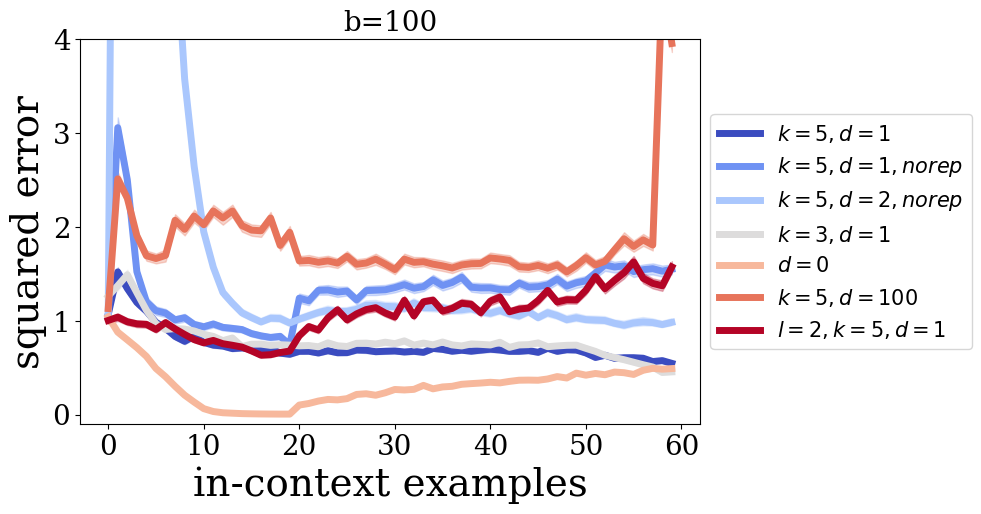

In [ ]:
ls, lw, fs = 28, 5, 15
ax = plot_results(res)
plt.rc('font', family='serif')
ax.set_ylim(-0.1, 4)
ax.set_title("b=100", fontsize=20)
ax.set_xlabel("in-context examples", fontsize=ls)
ax.set_ylabel("squared error", fontsize=ls)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fs)

## Loop iterations

In [ ]:
def pointwise_error(preds, ys):
    # get mean across points for each loop
    return torch.nanmean((preds - ys).square(), dim=-1).T

In [ ]:
errs = {}
for k, v in runs1.items():
    cfg = get_config(cfg_dict=v.config, overrides=eval_overrides)
    loc = Path("../"+v.config['out_dir'])
    loc = loc/'model_last.pt' if (loc/'model_last.pt').exists() else loc/'model_90000+train.pt'
    errs[k] = eval(cfg, loc, pointwise_error) 
res = aggregate_metrics(errs, cfg.task.n_dims)

<matplotlib.legend.Legend>

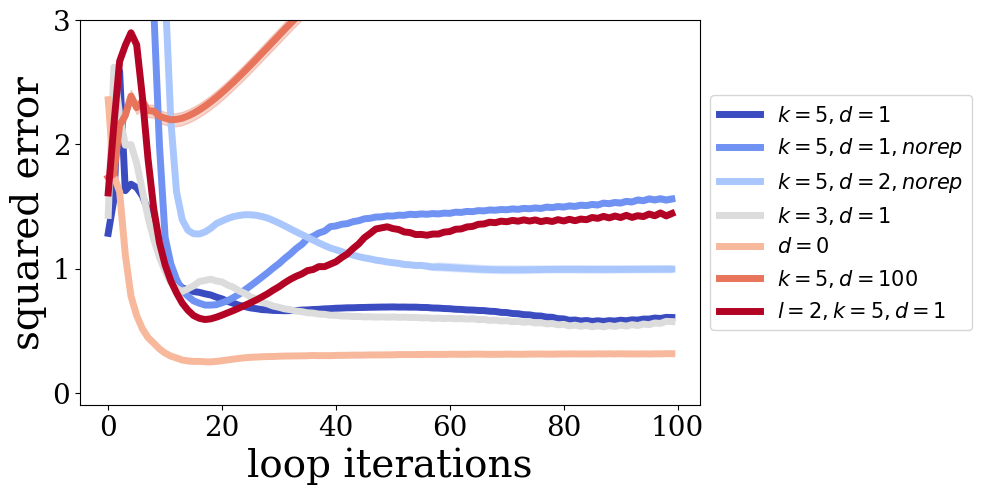

In [ ]:
ax = plot_results(res)
ax.set_ylim(-0.1, 3)
ax.set_xlabel("loop iterations", fontsize=ls)
ax.set_ylabel("squared error", fontsize=ls)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fs)

# $T=10, b=30$
### In-context examples

In [ ]:
runs2 = {}
runs2[r"$d=0$"]= runs.pop('loop_L1_b30_T10')
runs2[r"$k=3, d=1$"]= runs.pop('loop_L1_b30_T10_k3_d1')
runs2[r"$k=5, d=2$"]= runs.pop('loop_L1_b30_T10_k5_d2')
runs2[r"$k=5, d=5$"]= runs.pop('loop_L1_b30_T10_k5_d5')

In [ ]:
errs = {}
for k, v in runs2.items():
    cfg = get_config(cfg_dict=v.config, overrides=eval_overrides)
    loc = Path("../"+v.config['out_dir'])
    loc = loc/'model_last.pt' if (loc/'model_last.pt').exists() else loc/'model_90000+train.pt'
    errs[k] = eval(cfg, loc) 
res = aggregate_metrics(errs, cfg.task.n_dims)

<matplotlib.legend.Legend>

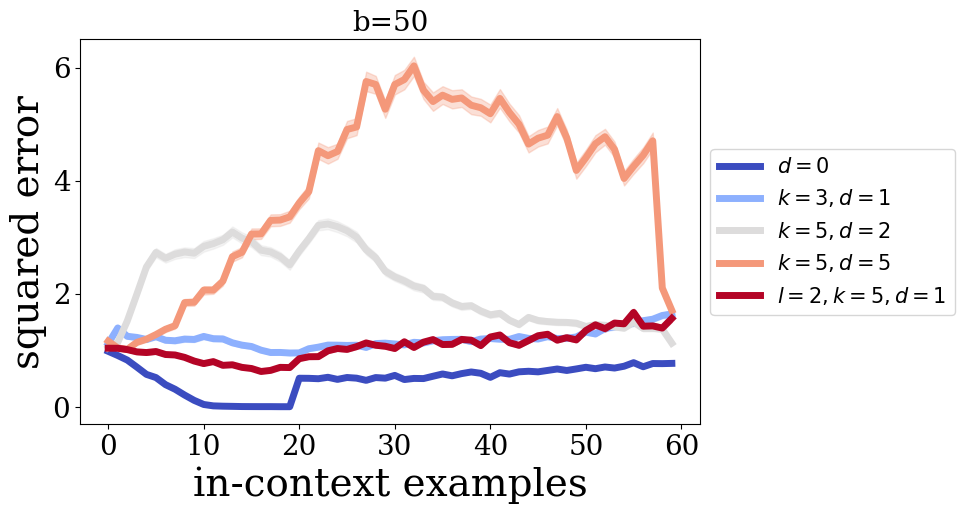

In [ ]:
ls, lw, fs = 28, 5, 15
ax = plot_results(res)
plt.rc('font', family='serif')
# ax.set_ylim(-0.1, 1.25)
ax.set_title("b=50", fontsize=20)
ax.set_xlabel("in-context examples", fontsize=ls)
ax.set_ylabel("squared error", fontsize=ls)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fs)

### Loop-iterations

In [ ]:
errs = {}
for k, v in runs2.items():
    cfg = get_config(cfg_dict=v.config, overrides=eval_overrides)
    loc = Path("../"+v.config['out_dir'])
    loc = loc/'model_last.pt' if (loc/'model_last.pt').exists() else loc/'model_90000+train.pt'
    errs[k] = eval(cfg, loc, pointwise_error) 
res = aggregate_metrics(errs, cfg.task.n_dims)

<matplotlib.legend.Legend>

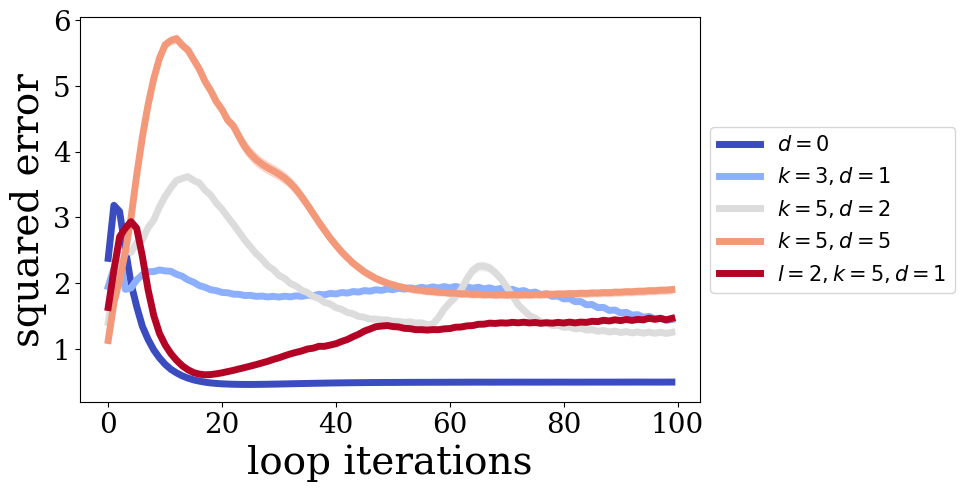

In [ ]:
ax = plot_results(res)
ax.set_xlabel("loop iterations", fontsize=ls)
ax.set_ylabel("squared error", fontsize=ls)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fs)